![alt text](lenet_architecture.png)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [5]:
len(y_train), len(y_test)

(50000, 10000)

In [6]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [7]:
X_train /= 255.
X_test /= 255.

In [8]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

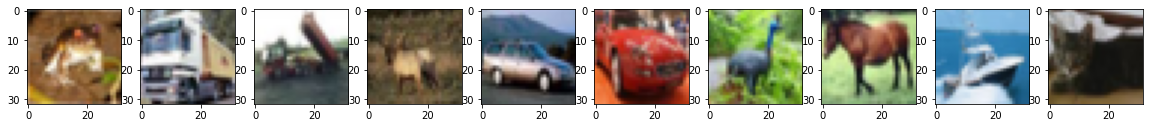

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [10]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [11]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [12]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [13]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [14]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
    #optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    optimizer = torch.optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []
    train_accuracy_history = []
    train_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        train_loss_history.append(loss(preds, y_batch).data.cpu())
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (preds.argmax(dim=1) == y_batch).float().mean().data.cpu()
        train_accuracy_history.append(accuracy)
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    del net
    return train_accuracy_history, test_accuracy_history, train_loss_history, test_loss_history

accuracies_train = {}
accuracies_test = {}
losses_train = {}
losses_test = {}



In [15]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.RReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.drop1 = torch.nn.Dropout(p=0.1)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.RReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.drop2 = torch.nn.Dropout(p=0.1)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.RReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(2, 2)
        self.drop3 = torch.nn.Dropout(p=0.1)

        self.conv4 = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.act4  = torch.nn.RReLU()
        self.batch_norm4 = torch.nn.BatchNorm2d(128)
        self.drop4 = torch.nn.Dropout(p=0.1)

        self.fc1   = torch.nn.Linear(4 * 4 * 128, 512)
        self.act5  = torch.nn.RReLU()
        self.batch_norm5 = torch.nn.BatchNorm1d(512)
        self.drop5 = torch.nn.Dropout(p=0.1)
        
        self.fc2   = torch.nn.Linear(512, 256)
        self.act6  = torch.nn.RReLU()
        self.batch_norm6 = torch.nn.BatchNorm1d(256)
        self.drop6 = torch.nn.Dropout(p=0.1)

        self.fc3   = torch.nn.Linear(256, 64)
        self.act7  = torch.nn.RReLU()
        self.batch_norm7 = torch.nn.BatchNorm1d(64)
        self.drop7 = torch.nn.Dropout(p=0.1)
        
        self.fc4   = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.conv4(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.drop4(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.drop5(x)

        x = self.fc2(x)
        x = self.act6(x)
        x = self.batch_norm6(x)
        x = self.drop6(x)


        x = self.fc3(x)
        x = self.act7(x)
        x = self.batch_norm7(x)
        x = self.drop7(x)


        x = self.fc4(x)
        
        return x

In [16]:
accuracies_train['cifar_net'], accuracies_test['cifar_net'], losses_train['cifar_net'], losses_test['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)

tensor(0.6514)
tensor(0.6895)
tensor(0.7313)
tensor(0.7483)
tensor(0.7555)
tensor(0.7667)
tensor(0.7734)
tensor(0.7634)
tensor(0.7774)
tensor(0.7792)
tensor(0.7907)
tensor(0.7757)
tensor(0.7991)
tensor(0.7962)
tensor(0.8044)
tensor(0.7983)
tensor(0.8000)
tensor(0.8019)
tensor(0.8128)
tensor(0.8097)
tensor(0.8023)
tensor(0.8086)
tensor(0.8049)
tensor(0.8107)
tensor(0.8106)
tensor(0.8130)
tensor(0.8124)
tensor(0.8122)
tensor(0.8117)
tensor(0.8095)


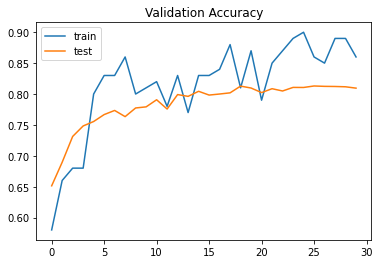

In [17]:
plt.plot(accuracies_train['cifar_net'], label='train')
plt.plot(accuracies_test['cifar_net'], label='test')
plt.legend()
plt.title('Validation Accuracy');

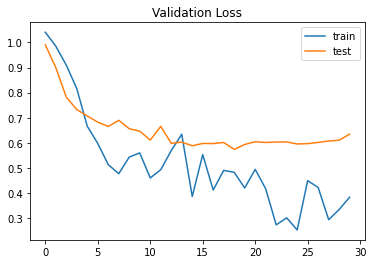

In [18]:
plt.plot(losses_train['cifar_net'], label='train')
plt.plot(losses_test['cifar_net'], label='test')
plt.legend()
plt.title('Validation Loss');

Значение Accuracy для сети cifar_net достигло 0.81. 

Для достижения данного результата был изменен метод оптимизатора ошибки на Adadelta. Функции активации после каждого из слоев были изменены на RReLU.

Также был добавлен один сверточный слой и один полносвязный слой.

Чтобы избежать быстрое переобучение, был использован метод Dropout для выключения отдельных весов после каждого слоя.

Были построены графики на трейне и на тесте. На тесте практически исчезло переобучение.

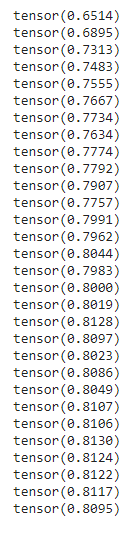

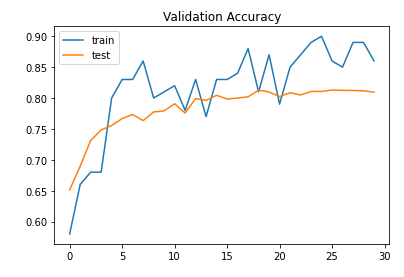

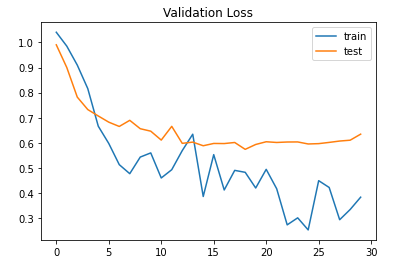